# Quadratic Unconstrained Binary Optimization (QUBO)
### QWorld Lessons (Womanium QCobalt, Module 4)

In QUBO, we encode an optimization problem in at most quadratic terms of $n$ binary variables $x_i=0\lor 1$. QUBO can be then encoded as a problem with $\frac{1}{2}n(n+1)$ coefficients for all possible multiplications of $x_ix_j$ and represented as an upper-tiangular matrix, where we want to find the binary vector $x$ that minimizes $x^\top Q x$. Quantum annealing offers exponential speedup to search for $x$ over classical methods (such as simulated annealing).

qubo_solver ran in 0.000070s
(-2, [array([0, 0, 1, 0]), array([0, 1, 0, 0]), array([0, 1, 1, 0])])
qubo_solver ran in 0.000064s
(17, [array([1, 1, 1, 1])])


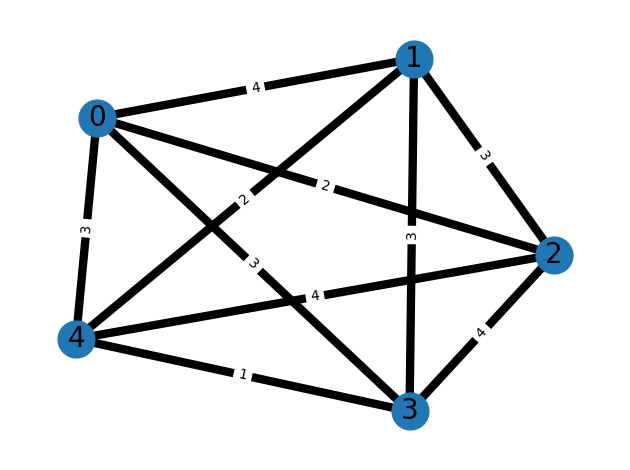

In [2]:
import numpy as np
import itertools
from collections import defaultdict
import re, sys, os
import networkx as nx
import matplotlib.pyplot as plt
# import some utilities
sys.path.append(os.getcwd()+'/..')
from util import uFormat, timeIt
from quantum_util import plot_op

@timeIt
def qubo_solver(Q_matrix, offset=0):
    """ a brute-force qubo_solver 
    offset: add to the minimum values of the objective function"""
    possible_values = defaultdict(list)
    # A list of all the possible permutations for x vector
    vec_permutations = itertools.product([0, 1], repeat=Q_matrix.shape[0])

    min_val = np.inf
    for permutation in vec_permutations:
        x = np.array(permutation)
        value = x @ Q_matrix @ x.T + offset
        possible_values[value].append(x)
        if value < min_val: min_val = value

    opt_vecs = possible_values[min_val]
    return min_val, opt_vecs

def qubo_solver_max(Q):
    min_val, opt_vecs = qubo_solver(-Q)
    return -min_val, opt_vecs

Q = np.array([[1, 4, 0, 3], 
              [4, -2, 1, 2], 
              [0, 1, -2, -1],
              [0, 2, 4, 0]])
print(qubo_solver(Q))
print(qubo_solver_max(Q))

def graph_viz(G: nx.Graph):
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

    pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
    nx.draw_networkx_edges(
        G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
    )

    # node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

n = 5
G = nx.complete_graph(n)
for u, v in G.edges():
    G[u][v]["weight"] = np.random.randint(1,n)
graph_viz(G)

## Adding Constraints (Penalty Method)
To add a constraint $g$, it is equivalent to add a loss to the objective such that the constraint is obeyed in the optimal solution, according to some tuning parameter $P$ that ensures the constraint is satisfied without any additional loss in the quality of reaching other constraints or desired objectives. 

For each constraint $g_j(y_1,\dots,y_k)$, where $\sum a_i y_i = b_j$, we add to the unconstrained objective function $f(y_1,\dots,y_k)$:
$$\sum_j P_j \cdot\left(\sum_i \left( a_iy_i \right) - b\right)^2$$

To add a single constraint, we can expand:
$$\begin{aligned} \left(\sum_i a_i y_i - b \right)^2 &= \sum_i\sum_j a_i y_i a_j y_j - 2 b \sum_i a_i y_i + b^2 
\\ &= \sum_i a_i y_i \left[\left(a_i - 2 b \right) + 2\sum_{j>i} a_j y_j\right] + b^2 \end{aligned}$$

We can equate less-than and greater-than constraints by simply adding a slack variable that turns into a regular equation:
$$\sum a_i y_i \le b_j \to \sum a_i y_i = b_j + \eta_j$$

When $\eta$ is positive when we encounter a less than constraint and negative when we encounter a greater than constraint.





In [ ]:
# hidden tests will be used for grading.

# for X <= b, we say X - eta = b, and let eta be the slack variable eta >= 0
# for X >= b, let eta be the slack variable eta <= 0
def qubo_constraint_inplace(Q, weights: dict[int:float], b, eta=0) -> float:
    """ add constraint to Q matrix in-place, 
        with weights indexed by an integer index 
    returns: offset to add to the cost later """
    # eta = slack variable
    indices = list(weights.items())
    n = len(indices)
    w = b + eta
    offset = w**2  # need to add this to the objective later
    for i in range(n):
        k, v = indices[i]   # k is the variable index, v is the weight
        if v == 0: continue
        if isinstance(k, tuple):  # allow indexing of diagonal elements
            assert len(k) == 2 and k[0] == k[1]
            k = k[0]
        Q[k, k] += v * (v - 2 * w)
        for j in range(i+1, n):
            k2, v2 = indices[j]
            if isinstance(k2, tuple):  # allow indexing of diagonal elements
                assert len(k2) == 2 and k2[0] == k2[1]
                k2 = k2[0]
            if k2 >= k:
                Q[k, k2] += 2 * v * v2
            else:
                Q[k2, k] += 2 * v * v2
    return offset

def qubo_constraint(weights: list | dict, b, eta=0) -> tuple[np.ndarray, float]:
    """ return QUBO matrix for the constraint weights•x - eta = b 
      eta >= 0 when weights•x <= b, and eta <= 0 when weights•x >= b"""
    # eta = slack variable
    n = len(weights)
    Q = np.zeros((n,n))
    if isinstance(weights, dict):
        offset = qubo_constraint_inplace(Q, weights, b, eta)
        return Q, offset
    w = b + eta
    offset = w**2  # need to add this to the objective later
    for i in range(n):
        if not weights[i]: continue
        Q[i, i] = weights[i] * (weights[i] - 2 * w)
        for j in range(i+1, n):
            Q[i, j] = 2 * weights[i] * weights[j]
    return Q, offset


def str_to_weights(nvars: int, weights: str) -> dict[tuple[int,int],float]:
    """ parse weights of the form "2x_0 + 3x_1x_2 -4x_2" into a dictionary
     - accepts variables as x or y
     - variables are zero-indexed, with index following as either x_0 or x0 """
    Q = defaultdict(float)
    coeff = 1; gettingIndex = 0; idxs = False
    i = 0
    while i < len(weights):
        ch = weights[i]
        # get coefficient
        if ch == '-':
            if gettingIndex == 1:
                # only one variable, on next term
                Q[idxs] += coeff
                coeff = 1; idxs = False
            coeff *= -1
            gettingIndex = 0
        elif ch == '+':
            if gettingIndex == 1:
                # only one variable, on next term
                Q[idxs] += coeff
                coeff = 1; idxs = False
            #coeff = 1
            gettingIndex = 0
        elif ch.isdigit():
            # get number representing coefficient
            j = i
            while j < len(weights):
                if not weights[j].isdigit():
                    break
                j += 1
            num = int(weights[i:j])
            if num >= nvars and gettingIndex:
                raise ValueError(f"index {num} out of bounds (0-{nvars-1}) for variable at end of '{weights[:i+1]}'.")
            if gettingIndex == 1:  # we are on first x_(idx)
                idxs = (num, num)
            elif gettingIndex == 2:  # we are on second x_(idx)
                if num > idxs[0]:
                    idxs = (idxs[0], num)
                else:
                    idxs = (num, idxs[0])
                Q[idxs] += coeff
                coeff = 1; gettingIndex = 0; idxs = False
            else:  # we are on coefficient
                coeff *= num
            i = j - 1  # want i = j but adding later
        elif ch in ('x','y'):
            if gettingIndex and isinstance(idxs, bool):
                # did not specify a number after another x
                raise ValueError(f"error at end of '{weights[:i+1]}'.made \n{Q}")
            gettingIndex += 1
        i += 1
    if gettingIndex == 1:  # we have leftover coefficient!
        Q[idxs] += coeff
    return Q


def qubo_objective(nvars: int, weights: list | dict | str, maximize=False):
    """
    nvars: number of binary variables
    weights: encode objective function as either
      1. a list of weights nvars long, assuming just linear constraints
      2. a dictionary mapping int (linear) or tuple[int,int] to weights 
      3. a string of the form "2x_0 + 3x_1x_2 -4x_2 " from which we can parse the weights
        - variables are zero-indexed
    maximize: maximize instead of minimize said objective
    """
    Q = np.zeros((nvars, nvars))
    if isinstance(weights, list) or isinstance(weights, np.ndarray):
        if len(weights) != nvars:
            raise ValueError(f"{nvars} nvars but weights is of length {len(weights)}")
        for i in range(nvars):
            Q[i, i] = weights[i]
    else:
        if isinstance(weights, str):
            weights = str_to_weights(nvars, weights)
        if not isinstance(weights, dict):
            raise ValueError("weights must be a list, dict, or string")
        for k, v in weights.items():
            if isinstance(k, int):
                Q[k, k] += v
            else:
                if len(k) != 2:
                    raise ValueError(f"key must be of length 2 for quadratic terms but is {k}")
                if k[1] > k[0]:
                    # ensure upper triangular matrix
                    Q[k[0], k[1]] += v
                else:
                    Q[k[1], k[0]] += v
    if maximize:
        return -Q
    return Q


#TODO: how do we add a slack variable eta?
# do we allocate a set of binary variables to encode
# the sum of the slack variable? or just choose different weightings
# to add to eta when doing the constraint?
#TODO: do we need to expand the Q matrix to include the slack variable
def qubo_from_str(nvars: int, input: str):
    """ input contains lines for objective function(s) and any constraint(s)
     - objective function is of the form "2x_0 + 3x_1x_2 -4x_2" and is minimized
     - constraints are of the form "x_0 + x_1 <= 2" and must be linear
    the objective + multiple constraints can be passed in a single string, separated 
    by the following line separators
    """
    separators = ('\.', ';', ':', '\n', ',')
    lines = re.split("|".join(separators), input)
    print(lines)
    Q = np.zeros((nvars, nvars))
    constraint = np.zeros((nvars, nvars))
    offset = 0
    for line in lines:
        # constraint possibilities
        parts = re.split("<=|>=|=", line)
        if len(parts) == 2:
            weights = str_to_weights(nvars, parts[0]); b = int(parts[1].strip()); eta = 0
        else:
            parts = re.split("<|>", line)
            if len(parts) == 2:
                weights = str_to_weights(nvars, parts[0]); b = int(parts[1].strip())
                eta = -1 if "<" in line else 1  # add the slack variable to b
        if len(parts) == 2:  # add constraint
            offset += qubo_constraint_inplace(constraint, weights, b, eta)
        else:  # add objective
            Q += qubo_objective(nvars, line)
    # X > b  -->  X >= b + 1
    # X < b  -->  X <= b - 1
    P = Q.max() + 1
    return Q + P*constraint, offset

Q, offset = qubo_from_str(3,"x0+x1+x2 > 1")
print(Q, offset)

## Knapsack Problem

Given $n$ items, each with an associated weight $w_i$ and value $c_i$, we want to maximize the total value $\sum_ic_i$ of a knapsack such that its weight $\sum_iw_i$ is $\le$ the capacity $W$.

In the Unbounded Knapsack problem, each item can be used more than once, while in the Zero/One Knapsack problem, each item is either included or not and can be represented by a binary variable. 

Both of these can be solved in $\mathcal{O}(nW)$ time using dynamic programming, and therefore doesn't provide an exponential quantum advantage with QUBO.

Let $x_i$ be a binary variable that is equal to 1 if the $i$'th item is selected and 0 otherwise. This can be used to describe the Zero/One problem, and can generalize to the Unbounded problem if we assign multiple binary variables to represent the number of each item, which is at most $r=\lfloor W/\min_i(w_i)\rfloor$ repetitions, so we would need $n_v=\lceil \log_2\left(\lfloor W/\min_i(w_i)\rfloor\right)\rceil$ binary variables per item to be safe, which would mean needing $n_v*n$ binary variables total.


In [ ]:
# You can use this cell to call and check the output of the function

In [ ]:
W = 20
weights = [1, 4, 8, 2, 4, 4, 5]
values = [2, 7, 3, 4, 5, 6, 8]

def qubo_knapsack01(weights, values, W):
    nitems = len(weights)
    if len(values) != nitems:
        print(f"len(values)={len(values)} but len(weights)={len(weights)}")
    Q = np.zeros((nitems, nitems))
    # maximize value
    Q += qubo_objective(nitems, values, maximize=True)
    constraint, offset = qubo_constraint(weights, W)
    P = max(weights)+1
    Q += P*constraint
    return Q, offset*P

Q, offset = qubo_knapsack01(weights, values, W)
print(Q, offset)

print(qubo_solver(Q, offset))

$$f(x^1_0,x^1_1,x^1_2,x^1_3,x^2_0,x^2_1,x^2_2,x^\eta_0,x^\eta_1,x^\eta_2,x^\eta_3)+P \cdot \left(\sum_{j=0}^{2} 2^j x^1_j + x^1_3+ \sum_{j=0}^{1} 2^j x^2_j + 2x^2_2 + x^\eta_0 + 2x^\eta_1  +10\right)^2$$


## Higher Order Binary Optimization
Whenever we encounter higher orders in an objective or constraint, we "quadratize" the problem, reducing its order by one iteratively until the problem is quadratic. We do this by introducing new variables to eliminate a highest-order term once at a time, substituting $y_{ij} = x_ix_j$ and adding a new penalty term $C\cdot \left(x_ix_j - 2x_iy_{ij}-2x_jy_{ij}+3y_{ij}\right)$ to be minimized, negating this term for maximization.

Example: cubic problem with 3 variables turned into quadratic problem with 4 variables
$$\begin{aligned}
f(x_1,x_2,x_3) &= 5x_1+7x_1x_2-3x_1x_2x_3,\quad \text{define}\quad x_1x_2=y_{12} \
\to &= 5x_1+7y_{12}-3y_{12}x_3 + C\cdot \left(x_1x_2 - 2x_1y_{12}-2x_2y_{12}+3y_{12}\right) \
\end{aligned}$$

## Ising Model Equivalence

In the Ising model, binary variables are given the values $\sigma_i\in\{-1,1\}$ instead of $x_i\in\{0,1\}$. We can therefore convert using $x_i=\frac12(1+\sigma_i)$, $\sigma_i = 2x_i-1$.

$$H_\text{Ising} = \sum_i h_i \sigma_i + \sum_{i<j} J_{ij} \sigma_i \sigma_j$$



## Travelling Salesman Problem (TSP)

Goal: Find the Hamiltonian cycle with the smallest total cost in a graph $G$. We can always convert $G$ to a complete directed graph, by relabeling previously any nonexistent edges $(i,j)$ with extremely high costs $w_{ij}$. 

To formulate all possible $N$-length tours for $N$ nodes of a graph, we must use $N^2$ binary variables $x_{i,t}$, indexed by both their node $i$ and time visited $t$. Here we will index the variables from $1\dots N$ for sum representation convenience.

1. The cost of the tour is the cost of all of the edges we include in the Hamiltonian tour, so our objective function is to minimize $$\sum_{i\neq j}^N w_{ij} \left(x_{i,N}x_{j,1} + \sum_{t}^{N} x_{i,t} x_{j,t+1} \right)$$
1. We can only visit one node at each time point, so we add the constraint $$\sum_{i}^{N}x_{i,t} = 1 \quad \forall t\quad \to \sum_{t}^{N} \left(1-\sum_{i}^{N}x_{i,t}\right)^2$$
1. Likewise, we can only visit each node once, so we add the constraint
$$\sum_{t}^{N}x_{i,t} = 1 \quad\forall i\quad\to \sum_{i}^{N} \left(1-\sum_{t}^{N}x_{i,t}\right)^2$$

So in full, we must minimize 
$$P\left[\sum_{t}^{N} \left(1-\sum_{i}^{N}x_{i,t}\right)^2 + \sum_{i}^{N} \left(1-\sum_{t}^{N}x_{i,t}\right)^2\right] + \sum_{i\neq j}^N w_{ij} \left(x_{i,N}x_{j,1} + \sum_{t}^{N-1} x_{i,t} x_{j,t+1} \right)$$
where we choose $P>\max_{i,j}w_{ij}$
notice that the third term is essentially a triple-sum, as we must consider all $N(N+1)/2$ edges.

We can expand the constraint terms, noting that 
$$\left(1-\sum_i x_i\right)^2 = 1 - 2\sum_i x_i + \sum_i\sum_j x_i x_j = 1 + \sum_i x_i\left(-1 + 2\sum_{j>i} x_j\right)$$

so we will clearly have an offset of $2NP$ from the constraints.

$$\begin{aligned}
2NP + \sum_i^N\sum_t^N \left[ x_{i,t} \left(-1 + 2\sum_{j>i} x_{j,t}\right) + \right] 
\end{aligned}$$


In [ ]:

@timeIt
def tsp_qubo(edge_weights: np.ndarray):
    """
    returns QUBO matrix for the traveling salesman problem
    where each n rows is a new node x_(i,1) through x_(i,n)
    """
    n = edge_weights.shape[0]
    P = edge_weights.max() + 1
    Q = np.zeros((n**2, n**2))
    # only visit each node once
    for i in range(n):
        qubo_constraint_inplace(Q, {i*n + t: 1 for t in range(n)}, 1)
    # only visit one node at a time
    for t in range(n):
        qubo_constraint_inplace(Q, {i*n + t: 1 for i in range(n)}, 1)
    Q *= P
    offset = 2*n*P
    # minimize the cost of the edges
    for i in range(n):  # for each edge
        for j in range(n):
            if i == j: continue  # no self-loops
            for t in range(n-1):
                if j*n >= i*n + 1:
                    Q[i*n + t, j*n + t + 1] += edge_weights[i, j]
                else:
                    Q[j*n + t + 1, i*n + t] += edge_weights[i, j]
            if j*n >= i*n+n:  # connect cycle
                Q[i*n+n-1, j*n] += edge_weights[i, j]
            else:
                Q[j*n, i*n + n-1] += edge_weights[i, j]
    return Q, offset

W = np.array([[0, 1, 2, 3], 
              [1, 0, 4, 5], 
              [2, 4, 0, 6],
              [3, 5, 6, 0]])

Q, offset = tsp_qubo(W)
plot_op(Q)

## Graph Coloring

Assignment of colors to each vertex of a graph $G$ such that no adjacent vertices have the same color. 

Formulated on an undirected graph $G=(V,E)$ and check if a feasible coloring exists using $K$ colors.

Define $NK$ binary variables $x_{i,c}$ to assign all nodes $i$ a color $c$. 

Each node can only be colored once, and adjacent nodes must be assigned different colors, so the complete objective is
$$P_1 \sum_i^N \left(1-\sum_c^K x_{i,c}\right)^2 + P_2 \sum_{(i,j)\in E}\sum^K_c x_{i,c} x_{j,c} $$

and the total offset is the number of nodes, $N$.

If any constraints are violated, the total value will be greater than 0, and if none are, then the value will be 0. 

## Using D-Wave

#### Binary Quadratic Model (BQM)
Can represent QUBO using `vartype="BINARY"`and Ising using `vartype="SPIN"`, which you always need to specify. Can construct the data from either linear + quadratic dictionaries with either string or integer keys, or a numpy QUBO matrix. 

### Sampler
`ExactSolver()` runs all possible permutations to find exact solutions. 

`SimulatedAnnealingSampler` performs classical annealing to find the ground state. 
Parameters:
num_reads: how many runs to call
beta_schedule: 
num_sweeps:

In [1]:
from dimod import BinaryQuadraticModel as BQM
from dimod import ExactSolver, SimulatedAnnealingSampler

linear = {"x1": -5, "x2": -3, "x3": -8, "x4": -6}
quadratic = {("x1", "x2"): 4, ("x1", "x3"): 8, ("x2", "x3"): 2, ("x3", "x4"): 10}
vartype = "BINARY"

bqm_qubo = BQM(linear, quadratic, vartype, offset=0)
print(bqm_qubo.linear, bqm_qubo.quadratic, bqm_qubo.offset, bqm_qubo.vartype)
# need to pass order of fields if fielded originally
# get QUBO as np matrix
Q_new = bqm_qubo.to_numpy_matrix(['x1','x2','x3','x4'])
# get QUBO as dictionary, with offset
Q_dict, offset = bqm_qubo.to_qubo()
print('asdfasdf',Q_dict)
Q = np.array([[-5, 4, 8, 0],
              [0, -3, 2, 0],
              [0, 0, -8, 10],
              [0, 0, 0, -6]])
bqm_2 = BQM(Q, "BINARY")
bqm_1 = BQM.from_qubo(Q)  # don't need to specify vartype

print(Q_new)
print(bqm_1.linear, bqm_1.quadratic, bqm_1.offset, bqm_1.vartype)
bqm_qubo2 = BQM.from_qubo(Q_dict)
bqm_ising = BQM.from_ising(linear, quadratic, offset=0)
print(bqm_ising)

# find lowest energy using a classical sampler
sampler = ExactSolver()
sampleset = sampler.sample(bqm_qubo)
print(sampleset)
print(sampleset.lowest())
print(sampleset.first)

sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm_ising, num_reads=10)
print(sampleset)

ModuleNotFoundError: No module named 'dimod'

## Max-Cut Full Implementation

We want to bipartition an undirected graph $G=(V,E)$ so that the number of edges along the cut is maximal. We want to maximize 
$$\sum_{<i,j>} (x_i + x_j - 2x_ix_j)$$

Equivalently, we minimize
$$\sum_{(i,j)\in E}( 2x_ix_j-x_i-x_j) \equiv \sum_{(i,j)\in E} \sigma_i\sigma_j$$

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.turan_graph(5, 3)
fig, ax = plt.subplots(figsize=(6,6))
nx.draw(G, ax=ax)

d = defaultdict(int)
for i, j in G.edges:
    d[(i,j)] += 1
    d[(j,j)] += -1
    d[(i,i)] += -1

bqm = BQM.from_qubo(d)
sampler = ExactSolver()
sampleset = sampler.sample(bqm)
lowest = sampleset.lowest()

for vec in lowest:
    print(vec)
    H = nx.Graph()
    H.add_nodes_from(G)
    H.add_edges_from(G.edges)
    for k, v in vec.items():
        if not v:
            H.remove_node(k)
    fig, ax = plt.subplots(figsize=(6,6))
    nx.draw(H, ax=ax)


# Quantum Annealing

Relies on quantum adiabatic computation, a physical process in which quantum fluctuations act as "thermal" fluctutaions that explore the solution space. Quantum annealing relies on concepts present in adiabatic quantum computing, where eigenstates shift while transition dynamics are suppressed, but can still work on NISQ computers.

Adiabatically "shift" the initial Hamiltonian to a target Hamiltonian, so that 
$$H(t) = \left(1-\frac{t}{\tau}\right)H_0 + \frac{t}{\tau}H_p$$

D-Wave machines implement an Ising model on a quantum computer, where $h_i$ and $J_{ij}$ can be tuned. The problem Hamiltonian results in differently-weighted Pauli-z operations applied with the same form of the Ising model, which generates the following eigenenergies:

$$\begin{align*}
\varepsilon_P &= \sum_{i \in V} h_i (-1)^{\phi_i} + \sum_{(i,j) \in E} J_{ij} (-1)^{\phi_i}(-1)^{\phi_j} \\
&= \sum_{i \in V} h_is_i + \sum_{(i,j) \in E} J_{ij} s_i s_j
\end{align*}$$

### Accessing Real D-Wave Systems

BQMs operate on logical qubits, which are mapped to physical qubits in a process known as the *minor embedding*. As qubits only have a certain amount of nearest-neighbor connections, sometimes qubits are made redundant and called a *chain* so that one qubit gains access to more neighbors. 


In [ ]:
from dimod import BQM
from dwave.system import DWaveSampler, EmbeddingComposite

# embedding composite automatically maps the problem to 
# the qubits of the sampler
quadratic = {('s_1', 's_2'): 4}
vartype = "SPIN"
bqm = BQM(quadratic, vartype)

def tsp_bqm(G, P):
    N = len(G.nodes)
    bqm = BQM("BINARY")
    for i in range(N):
        for j in range(N):
            if i!=j:
                for t in range(N-1):
                    bqm.add_quadratic(f"x_{i}_{t}", f"x_{j}_{t+1}", G[i][j]["weight"])

                #Remember that we were assuming N=0 in the sum
                bqm.add_quadratic(f"x_{i}_{N-1}", f"x_{j}_{0}", G[i][j]["weight"])
    #Add the first constraint
    for t in range(N):
        c1 = [(f"x_{i}_{t}", 1) for i in range(N)] #coefficient list
        bqm.add_linear_equality_constraint(c1, constant=-1, lagrange_multiplier=P)
    #Add the second constraint
    for i in range(N):
        c2 = [(f"x_{i}_{t}", 1) for t in range(N)]
        bqm.add_linear_equality_constraint(c2, constant=-1, lagrange_multiplier=P)
    return bqm

def is_sample_feasible(sample,N):
    for i in range(N):
        if sum(sample[f"x_{i}_{t}"] for t in range(N))!=1:
            return False
    for t in range(N):
        if sum(sample[f"x_{i}_{t}"] for i in range(N))!=1:
            return False
    return True

def sample_to_path(sample,N):
    path = []
    for t in range(N):
        for i in range(N):
            if sample[f"x_{i}_{t}"] == 1:
                path.append(i)
    return path

def solve_tsp(G: nx.Graph, P):
    bqm = tsp_bqm(G, P)
    N = G.number_of_nodes()
    # NEED DWAVE API TO ACCESS
    try:
        sampler = EmbeddingComposite(DWaveSampler())
    except:
        sampler = SimulatedAnnealingSampler()
    sampleset_10 = sampler.sample(bqm_1, num_reads=10) 
    for s in sampleset_10.data():
        print(is_sample_feasible(s.sample,N))
        print(sample_to_path(s.sample,N),s.energy, s.chain_break_fraction)
np.random.seed(45)
N = 6
G1 = nx.complete_graph(N)
for u, v in G1.edges():
    G1[u][v]["weight"] = np.random.randint(1, 5)

solve_tsp(G1, 10)
